In [1]:
# !pip install -U "tensorflow==2.11"

import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
import time

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
import time

/Users/iskandre/miniconda/envs/macos210_py39/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/iskandre/miniconda/envs/macos210_py39/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/iskandre/miniconda/envs/macos210_py39/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/iskandre/miniconda/envs/macos210_py39/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/iskandre/miniconda/envs/macos210_py39/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlope

Installing Tensorflow Object Detection API

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [3]:
import sys
sys.path.append('models/research')
from object_detection.utils import label_map_util
from object_detection.utils import config_util
sys.path.append('models')
from object_detection.builders import model_builder

In case you're running from Google Colab, run the following code block

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Model preparation

I am using pre-trained CenterNet MobileNetV2 FPN 512x512 model with the fine tuning following after.

It is important to choose only the models with SSD architecture as only the models based on SSD architecture are currenty supported for converting into TensorFlow Lite format. As we are planning to run the inference on Coral Edge device for real time streaming, we need TFlite format. 

Regarding TPU compatibility, Currently, SSDMetaArch models are supported on TPUs. FasterRCNNMetaArch is going to be supported in the future.

Download pre-trained CenterNet MobileNetV2 FPN 512x512 model http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz


### Restoring weights from pre-trained model

Update model_lib_v2.py with partial restoring of the pre-trained model.

The detection model consists of the feature extractor detection_model._feature_extractor (MobilenetV2 FPN Feature Extractor in this case) and the heads predictor detection_model._box_predictor.

The heads predictor stars with the early layers base_tower_layers_for_heads followed by the class prediction and box regression heads.
_box_prediction_head predicts the bounding boxes while _prediction_heads predicts the category. The default pretrained model is pre-trained on 90 COCO categories. We keep base_tower_layers_for_heads and _box_prediction_head for partial restoring. However we won't restore _prediction_heads becauseand we want to have new classes and the number different from 90 as the default one. Thus, after partially restoring we can start re-training the model. This is the work flow for creating new classes.

In [ ]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads = detection_model._box_predictor._prediction_heads,
    # will not restore the classifiction head
    _box_prediction_head = detection_model._box_predictor._box_prediction_head,
    _head_scope_conv_layers = detection_model._box_predictor._head_scope_conv_layers
)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor = fake_box_predictor
)

model_checkpoint = tf.compat.v2.train.Checkpoint(model = tmp_model_checkpoint)
model_checkpoint.restore(train_config.fine_tune_checkpoint).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

However, in our case we work with cats. This category already exists in those 90 pre-trained COCO categories. Therefore it makes sense to load the weights particularly for this category only.

That's what my script below does. Basically, we just need to take depthwise_kernel, pointwise kernel and bias weights for the cat category (number 17 in COCO label map) from pre-trained category and assign to our new detection model.

We can retrieve, for example, pointwise kernel from the checkpoint as reader.get_tensor('model/_box_predictor/_prediction_heads/class_predictions_with_background/_class_predictor_layers/0/pointwise_kernel/.ATTRIBUTES/VARIABLE_VALUE')

It has the shape (1, 1, 128, 546) where 546 stands for background_class (the first 6 elements) + 90 classes (each with 6 elements). As the cat corresponds to the category number 17, to get the the depthwise kernel for cats we need to extract like this pointwise_kernel[:,:,:,6*18:6*19]].

In [ ]:
# Here is the code to modify model_lib_v2.py in Object Detection API 
# after restoring the weights from the donwloaded pre-trained model

reader = tf.train.load_checkpoint(train_config.fine_tune_checkpoint)
head_pred_vars = [x for x in detection_model._box_predictor._prediction_heads.get('class_predictions_with_background').trainable_variables]
pointwise_kernel = reader.get_tensor('model/_box_predictor/_prediction_heads/class_predictions_with_background/_class_predictor_layers/0/pointwise_kernel/.ATTRIBUTES/VARIABLE_VALUE')
# (1, 1, 128, 546)

depthwise_kernel = reader.get_tensor('model/_box_predictor/_prediction_heads/class_predictions_with_background/_class_predictor_layers/0/depthwise_kernel/.ATTRIBUTES/VARIABLE_VALUE')
# (3, 3, 128, 1)

bias = reader.get_tensor('model/_box_predictor/_prediction_heads/class_predictions_with_background/_class_predictor_layers/0/bias/.ATTRIBUTES/VARIABLE_VALUE')
# (546,)

# depthwise_kernel
assert(head_pred_vars[0].shape == depthwise_kernel.shape)
tf.compat.v1.assign(detection_model._box_predictor._prediction_heads.get('class_predictions_with_background').trainable_variables[0], depthwise_kernel)

filtered_pointwise_kernel = tf.concat([pointwise_kernel[:,:,:,:6], pointwise_kernel[:,:,:,6*18:6*19]],axis = -1)
assert(head_pred_vars[1].shape == filtered_pointwise_kernel.shape)
tf.compat.v1.assign(detection_model._box_predictor._prediction_heads.get('class_predictions_with_background').trainable_variables[1], filtered_pointwise_kernel)

filtered_bias = tf.concat([bias[:6],bias[6*18:6*19]], 0)
assert(head_pred_vars[2].shape == filtered_bias.shape)
tf.compat.v1.assign(detection_model._box_predictor._prediction_heads.get('class_predictions_with_background').trainable_variables[2], filtered_bias)


## Training with TPU

In [ ]:
!python3 models/research/object_detection/model_main_tf2.py --model_dir gs://FOLDER_NAME/trained_tpu_ssd_model0 --use_tpu True --pipeline_config_path ssd_gc_pipeline.config

## Converting to TF Lite

### Exporting TFlite graph

First, we invoke export_tflite_graph_tf2.py to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

In [ ]:
!python3 models/research/object_detection/export_tflite_graph_tf2.py --pipeline_config_path ssd_gc_pipeline.config --trained_checkpoint_dir gs://FOLDER_NAME/trained_tpu_ssd_model0 --output_directory exported_ssd_tflite_model

Only SSD meta-architectures are supported for now. The expected output SavedModel would be in the directory exported_ssd_tflite_model (which is created if it does not exist).

### Post-training quantization

For the fully integer quantization (to run it on the Coral Edge device afterwards), we need a representative dataset for calibration. This dataset can be a small subset (around ~10–500 samples depending on each case) of the training or validation data. Here are two examples of representative dataset generator

In [41]:
# First option is to preprocess some relevant images from the directory
def representative_dataset():
    paths = os.listdir('mendel_pics')
    for path in paths:
        image = Image.open('mendel_pics/%s'%path).convert('RGB').resize((640,640), Image.ANTIALIAS)
        raw_inp = (2.0 / 255.0) * np.asarray(image) - 1.0
        raw_inp = raw_inp.astype(np.float32)[np.newaxis,]
        yield [raw_inp]

In [ ]:
# Second option is to generate train input from the config 

import sys
sys.path.append('models/research')
from object_detection import inputs

pipeline_config_path = '/content/ssd_haro_colab_full.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)

train_input = inputs.train_input(
          train_config=configs['train_config'],
          train_input_config=configs['train_input_config'],
          model_config=configs['model'])
          
def representative_dataset():
    paths = []
    for i in range(0,20):
        features, labels = next(iter(train_input))
        img = features['image'][0,:,:,:]
        raw_inp = tf.cast(img, tf.float32)[tf.newaxis, :]
        proc_inp = (2.0 / 255.0) * raw_inp - 1.0 # normalization
        yield [proc_inp]

In [ ]:
import sys
sys.path.append('models/research')
from object_detection import inputs

pipeline_config_path = '/content/ssd_gc_pipeline.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)

train_input = inputs.train_input(
          train_config=configs['train_config'],
          train_input_config=configs['train_input_config'],
          model_config=configs['model'])

def representative_dataset():
    paths = []
    for i in range(0,20):
        features, labels = next(iter(train_input))
        img = features['image'][0,:,:,:]
        raw_inp = tf.cast(img, tf.float32)[tf.newaxis, :]
        proc_inp = (2.0 / 255.0) * raw_inp - 1.0 # normalization
        yield [proc_inp]

The data must be normalized. In our model SSD Feature Extractor has embedded pre-processor.

preprocessed_images = (2.0 / 255.0) * raw_inp - 1.0

This formula matches with mean=127.5 and std=127.5 as in the documentation
https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters

The Edge TPU hardware requires all parameters and activations to be quantized to integers. 

Here is the full table how to decide which quantization technique you would need.
https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
converter =  tf.lite.TFLiteConverter.from_saved_model('/content/exported_ssd_tflite_model/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.allow_custom_ops = True
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

with open('model_integer_quant.tflite', 'wb') as w:
    w.write(tflite_model)

Compile it with edgetpu_compiler

In [ ]:
!edgetpu_compiler model_integer_quant.tflite --show_operations

The result will look like this:

- Number of operations that will run on Edge TPU: 111
- Number of operations that will run on CPU: 52

In [44]:
# How to install edgetpu_compiler if needed
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

## Running the inference on Edge TPU device

In [6]:
from pycoral.adapters import common
from pycoral.utils.edgetpu import make_interpreter

interpreter = make_interpreter('model_float_edgetpu.tflite')

interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

scale = input_details[0]['quantization_parameters']['scales']
zero_point = input_details[0]['quantization_parameters']['zero_points']
output_scale = output_details[0]['quantization_parameters']['scales']
output_zero_point = output_details[0]['quantization_parameters']['zero_points']

In [23]:
# I need vertical flip Image.FLIP_TOP_BOTTOM because of my camera setup
image = Image.open('some_test_image.jpg').transpose(Image.FLIP_TOP_BOTTOM).convert('RGB').resize((640,640), Image.ANTIALIAS)
img_tensor = tf.convert_to_tensor(image, dtype = tf.uint8)

raw_inp = tf.cast(img_tensor, tf.float32)[tf.newaxis, :]
preprocessed_images = (2.0 / 255.0) * raw_inp - 1.0 

<ipython-input-23-88c232ece659>:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = Image.open('/Users/iskandre/Documents/Coursera/tensorflow advanced vision/mendel_files/corridor_stream1/corridor_81.jpg').transpose(Image.FLIP_TOP_BOTTOM).convert('RGB').resize((640,640), Image.ANTIALIAS)


In [24]:
interpreter.set_tensor(input_details[0]['index'], preprocessed_images.numpy().astype('float32'))
interpreter.invoke()

In [25]:
output_data = interpreter.get_tensor(output_details[1]['index'])
detected_keypoints = [output_data[0,0,:2],output_data[0,0,2:]]

In [27]:
from object_detection.utils import visualization_utils as viz_utils

In [29]:
viz_utils.draw_bounding_box_on_image(image, *detected_keypoints[1], *detected_keypoints[0])

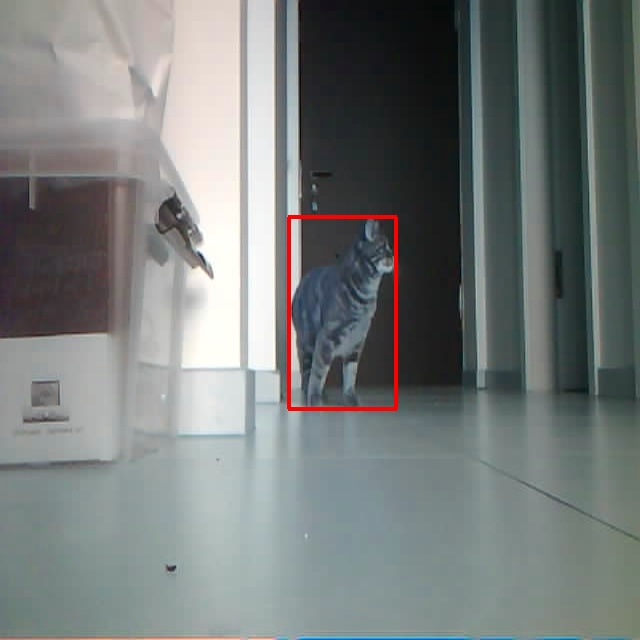

In [30]:
image

To run inference on streaming video, you would need the code similar to the one below

In [ ]:
import cv2
cap = cv2.VideoCapture('http://IP_ADDRESS:5050/video')
while True:
    ret, frame = cap.read()
    cv2_im_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.resize(cv2_im_rgb, (640,640))
    # convert to PIL Image 
    im_pil = Image.fromarray(image)
    # here run the inference